In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sys.path import insert
from os.path import join
from scipy import stats

In [2]:
data_dir = 'Datafiles'
aferesis_file = join(data_dir,'AFERESIS_edit.xlsx')


In [3]:
with open(aferesis_file, 'rb') as file:
    # --Reading sheet to get oldmethod sample
    df_OldMeth = pd.read_excel(
        file,
        sheet_name='COLECTAS_METODO_VIEJO',
        header=0,
        nrows=212
    )

    # --Reading sheet to get newmethod sample
    df_NewMeth = pd.read_excel(
        file,
        sheet_name='COLECTAS_METODO_NUEVO',
        header=0,
        nrows=77
#         nrows=79
    )
    
    def rename_cols(DataFrame):
        DataFrame.columns = [
            'Paciente','Fecha','Tipo_transplante','Num_Colecta','Tiempo [min]',
            'ACD [ml]','Volumen [ml]','DMSO [ml]','Volemias?','CMN','CD34',
            'Sum_CMN','Sum_CD34','Inutil','Harvest'
        ]
        return
        
    rename_cols(df_OldMeth)
    rename_cols(df_NewMeth)
#     df_OldMeth['Fecha'].dtype = pd.Timestamp.date
#     print(type(df_OldMeth['Fecha'].to_datetime.date))
#     pd.to_datetime.date()

In [4]:
# df_OldMeth.tail(10)
df_OldMeth.head(10)
# df_OldMeth['Paciente'].unique()

# --Padding col Paciente.
df_OldMeth['Paciente'].fillna(method='pad',inplace=True)

print(df_OldMeth.columns[4:])
for col in df_OldMeth.columns[4:]:
    df_OldMeth.loc[:,col].replace(to_replace='ND',value=np.NaN,inplace=True)

Index(['Tiempo [min]', 'ACD [ml]', 'Volumen [ml]', 'DMSO [ml]', 'Volemias?',
       'CMN', 'CD34', 'Sum_CMN', 'Sum_CD34', 'Inutil', 'Harvest'],
      dtype='object')


In [5]:

# --Padding col Paciente.
df_NewMeth['Paciente'].fillna(method='pad',inplace=True)
# df_NewMeth.head(10)

# --Fill NaN values
for col in df_NewMeth.columns[4:]:
    df_NewMeth.loc[:,col].replace(to_replace='ND',value=np.NaN,inplace=True)
    

In [6]:
df_OldMeth.head(10)

,Paciente,Fecha,Tipo_transplante,Num_Colecta,Tiempo [min],ACD [ml],Volumen [ml],DMSO [ml],Volemias?,CMN,CD34,Sum_CMN,Sum_CD34,Inutil,Harvest
0,1.0,2014-10-21,AUTO,1,NaN,NaN,384.0,38.4,NaN,0.57,5.93,0.57,5.93,0,NO
1,1.0,2014-10-22,AUTO,2,NaN,NaN,256.0,25.6,NaN,0.42,4,0.99,9.93,1,NO
2,1.0,2014-10-23,AUTO,3,NaN,NaN,298.0,29.8,NaN,0.63,4.1,1.62,14.03,1,NO
3,1.0,2014-10-24,AUTO,4,NaN,NaN,306.0,30.6,NaN,0.66,4.61,2.28,18.64,1,NO
4,2.0,2014-11-02,AUTO,1,180.0,600.0,290.0,29.0,1.654135,4.03,NaN,4.03,NaN,0,NO
5,3.0,2014-11-03,AUTO,1,NaN,NaN,260.0,26.0,NaN,1.37,NaN,1.37,NaN,0,NO
6,3.0,2014-11-03,AUTO,2,200.0,700.0,295.0,29.5,1.640000,3.78,NaN,5.15,NaN,0,NO
7,3.0,2014-11-04,AUTO,2,NaN,NaN,274.0,27.4,NaN,1.65,NaN,6.80,NaN,0,NO
8,3.0,2014-11-05,AUTO,3,NaN,NaN,206.0,20.6,NaN,1.84,NaN,8.64,NaN,0,NO
9,3.0,2014-11-06,AUTO,4,NaN,NaN,370.0,37.0,NaN,1.35,NaN,9.99,NaN,0,NO


In [7]:
# --remove useless cols
df_OldMeth.drop(axis='columns',labels=['Sum_CMN','Sum_CD34','Volemias?','Inutil','Harvest'], inplace=True)
df_NewMeth.drop(axis='columns',labels=['Sum_CMN','Sum_CD34','Volemias?','Inutil','Harvest'], inplace=True)

In [8]:
df_OldMeth.tail(10)

,Paciente,Fecha,Tipo_transplante,Num_Colecta,Tiempo [min],ACD [ml],Volumen [ml],DMSO [ml],CMN,CD34
202,77.0,2017-11-07,AUTO,2,187.0,598.0,300.0,30.0,2.07,1.96
203,78.0,2018-01-09,AUTO,1,191.0,915.0,326.0,32.6,3.01,5.09
204,78.0,2018-01-10,AUTO,2,130.0,518.0,220.0,22.0,1.60,8.61
205,79.0,2018-01-25,ALO,1,121.0,275.0,222.0,22.2,4.12,3.34
206,79.0,2018-01-26,ALO,2,79.0,275.0,152.0,15.2,3.02,3.7
207,80.0,2018-05-15,AUTO,1,217.0,946.0,259.0,25.9,4.31,0.45
208,80.0,2018-05-16,AUTO,2,188.0,832.0,250.0,25.0,2.27,0.34
209,80.0,2018-05-17,AUTO,3,196.0,764.0,270.0,27.0,4.06,0.33
210,81.0,2018-06-05,AUTO,1,120.0,499.0,160.0,16.0,8.28,3.17
211,81.0,2018-06-06,AUTO,2,156.0,694.0,250.0,25.0,12.05,5.99


In [9]:
df_NewMeth.tail(10)

,Paciente,Fecha,Tipo_transplante,Num_Colecta,Tiempo [min],ACD [ml],Volumen [ml],DMSO [ml],CMN,CD34
67,43.0,2019-10-15,AUTO,1,180,569,317.0,31.7,8.65,9.79
68,44.0,2019-10-15,AUTO,1,181,737,300.0,30.0,3.62,1.40
69,44.0,2019-10-16,AUTO,2,171,735,242.0,24.2,2.15,0.88
70,45.0,2019-11-14,AUTO,1,185,487,230.0,23.0,6.83,6.71
71,46.0,2019-11-21,AUTO,1,222,820,342.0,34.2,5.69,18.54
72,47.0,2019-12-03,AUTO,1,156,588,300.0,30.0,12.22,12.10
73,48.0,2020-01-22,AUTO,1,152,332,203.0,20.3,1.31,5.00
74,49.0,2020-02-04,AUTO,1,243,835,324.0,32.4,4.93,1.00
75,49.0,2020-02-05,AUTO,2,201,709,300.0,30.0,3.44,1.21
76,50.0,2020-02-27,AUTO,1,205,712,280.0,28.0,6.07,5.71


In [10]:
df_OldMeth['CD34'].isna().sum()

23

In [11]:
df_t = df_OldMeth.loc[:,['Paciente','CD34']].groupby(by='Paciente').sum()
df_t.tail()

,CD34
Paciente,
77.0,4.48
78.0,13.70
79.0,7.04
80.0,1.12
81.0,9.16


In [12]:
# print(

In [13]:
df_OldMeth.head(10)
# --Group NumColecta by Patient keeping maximum value
cols_toMax = ['Paciente','Num_Colecta']
df_Max_fixed = df_OldMeth.loc[:,cols_toMax].groupby(by='Paciente').max()

# --Group by Patient suming entries values
cols_toSum_vol = ['Paciente','Tiempo [min]','ACD [ml]','Volumen [ml]','DMSO [ml]']
df_Sum_vol = df_OldMeth.loc[:,cols_toSum_vol].groupby(by='Paciente').sum()

cols_toSum_CMN = ['Paciente','CMN']
df_Sum_CMN = df_OldMeth.loc[:,cols_toSum_CMN].groupby(by='Paciente').sum()

cols_toSum_CD34 =['Paciente','CD34']
df_Sum_CD34 = df_OldMeth.loc[:,cols_toSum_CD34].groupby(by='Paciente').sum()

# --Group Categorical by Patient
cols_toCat = ['Paciente','Tipo_transplante']
df_Cat_fixed = df_OldMeth.loc[:,cols_toCat].groupby(by='Paciente').first()

In [14]:
df_OldMeth['CD34'].dtype
# df_Sum_part.columns

dtype('O')

In [15]:
df_OldMeth = df_Max_fixed.join([df_Cat_fixed,df_Sum_vol,df_Sum_CMN,df_Sum_CD34],how='left')

In [16]:
df_OldMeth.head(10)

,Num_Colecta,Tipo_transplante,Tiempo [min],ACD [ml],Volumen [ml],DMSO [ml],CMN,CD34
Paciente,,,,,,,,
1.0,4,AUTO,0.0,0.0,1244.0,124.4,2.28,18.64
2.0,1,AUTO,180.0,600.0,290.0,29.0,4.03,0.00
3.0,4,AUTO,200.0,700.0,1405.0,140.5,9.99,0.00
4.0,5,AUTO,0.0,0.0,2050.0,205.0,3.86,0.00
5.0,2,AUTO,334.0,1477.0,483.0,48.3,2.79,1.72
6.0,2,AUTO,323.0,1367.0,455.0,45.5,6.31,0.24
7.0,5,AUTO,766.0,3182.0,1112.0,111.2,3.59,7.89
8.0,4,AUTO,547.0,2481.0,1352.0,135.2,4.91,39.88
9.0,2,AUTO,354.0,1168.0,337.0,33.7,9.30,5.08


In [17]:
CMN_units = f'10^8 [1/kg]'
# CMN_units
CD34_units = f'10^6 [1/kg]'
# CD34_units

In [19]:
# -- Get the actual histogram to compute operations
old_colect = df_OldMeth['Num_Colecta'].to_numpy()
# print(x)

In [20]:
N_old = old_colect.size
mean_old = np.round(old_colect.mean(),2)
std_old = np.round(old_colect.std(),2)
# mode_val =np.mode(x)

In [21]:
# print(f'mean: {mean_val}',f'standar_dev: {std_val}')
print(N_old,mean_old,std_old)

80 2.61 0.97


In [22]:
# stats.mode(x)

In [23]:
# # bin_edges,  = np.histogram(a=x,bins=5)
# print(hist)
# print(bin_edges)
# # plt.hist(a,bins='auto')
# # 

# # plt.bar(hist_val, width = 1)
# plt.bar(bin_edges[:-1], hist)
# plt.xlim(min(bin_edges), max(bin_edges))
# plt.show()   

In [24]:
# x =a[0].tolist()
# print(x)
# bins=a[1].tolist()`
# plt.hist

In [25]:
cols_toMax = ['Paciente','Num_Colecta']
df_New = df_NewMeth.loc[:,cols_toMax].groupby(by='Paciente').max()
df_New.head(10)

,Num_Colecta
Paciente,
1.0,1
2.0,1
3.0,1
4.0,1
5.0,2
6.0,3
7.0,1
8.0,1
9.0,1


In [26]:
new_colect = df_New['Num_Colecta'].to_numpy()

(array([30., 13.,  5.,  1.]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 <a list of 1 Patch objects>)

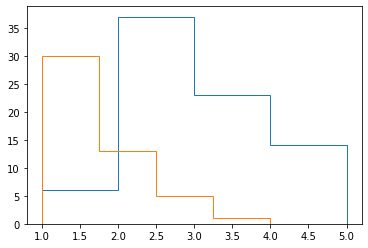

In [37]:
fig, ax = plt.subplots()

histo, bin_edges, unk = ax.hist(x=df_OldMeth['Num_Colecta'],bins=4,histtype='step')
ax.hist(new_colect,bins=4,histtype='step')

In [27]:
N_new = new_colect.size
mean_new = np.round(new_colect.mean(),2)
std_new = np.round(new_colect.std(),2)

In [28]:
print(N_new,mean_new,std_new)
print(N_old,mean_old,std_old)

49 1.53 0.76
80 2.61 0.97


In [29]:
# --computing T-Test from statistic
statistics, p_value= stats.ttest_ind_from_stats(
        mean_old, std_old, N_old,
        mean_new, std_new, N_new,
        equal_var=True)
# p_value = np.round(p_value*100,2)
print(statistics, p_value)

6.641325037272212 8.191269894165123e-10%


In [30]:
# --computing T-Test from sample
statistics2, p_value2 = stats.ttest_ind(old_colect, new_colect, axis=0, equal_var=True, nan_policy='omit')

In [31]:
print(p_value2)

9.293860637013722e-10


In [32]:
# -- Checking if population distribution is likely gaussian
statistics_dist, critical_vals, significance_lvls = stats.anderson(x=old_colect,dist='norm')

In [33]:
print(statistics_dist)

4.942476294641764


In [34]:
print(critical_vals)

[0.551 0.627 0.752 0.878 1.044]


In [35]:
print(significance_lvls)

[15.  10.   5.   2.5  1. ]
